In [4]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
# ! pip install pandas_datareader
import pandas_datareader.data as web

from sklearn.model_selection import train_test_split as tts
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.metrics import classification_report

from sklearn import metrics

import seaborn as sns

In [5]:
rawCovid = pd.read_csv("covid.csv")
variables = ["submission_date", "tot_cases", "new_case", "tot_death", "new_death"]
covid = rawCovid.loc[:,variables]

In [6]:
covid["submission_date"] = pd.to_datetime(covid["submission_date"])
covid.rename(columns={"submission_date":"Date"}, inplace=True)

In [7]:
weeklyCovid = covid.groupby(pd.Grouper(key = "Date", freq ="W")).sum()
weeklyCovid.reset_index(inplace=True)

weeklyCovid["case_change"] = weeklyCovid["tot_cases"].diff().fillna(0)
weeklyCovid["death_change"] = weeklyCovid["tot_death"].diff().fillna(0)
weeklyCovid["death_change"].fillna(0, inplace=True)

In [8]:
bioStock = ["FBRX", "TRIL", "CODX", "ALIM", "BTAI"]
pharmStock = ["ABT", "RCUS", "LLY", "ELAN", "MRK"]
techStocks = ["BILI", "CCOI", "CHT"]
energyStocks = ["CVX","XOM","KMI","WMB","LNG"]
retailStocks = ["WMT","AMZN","COST","BIG","ACI"]
consumerStaplesStocks= ['VDC', 'VCSAX']
utilityStocks= [ 'VUIAX', 'VPU']
realEstateStocks = ['AMT', 'PLD', 'EQIX', 'BAM', 'ZG']
healthCareStocks = ['JNJ', 'MDT', 'NVS', 'PFE', 'GSK']

In [9]:
tickerSymbol = bioStock + pharmStock + techStocks + energyStocks + retailStocks + consumerStaplesStocks + utilityStocks + realEstateStocks + healthCareStocks

In [10]:
start = "2020-01-22"
end = dt.now()

stocks = pd.DataFrame()
sc_df = pd.DataFrame()

for i in tickerSymbol:
    df = web.DataReader(i, "yahoo", start, end)
    df.reset_index(inplace=True)

    weeklyPrice = df.groupby([pd.Grouper(key="Date", freq="W")]).mean()
    weeklyPrice["Stock"] = i
    weeklyPrice.reset_index(inplace=True)
    
    stocks = stocks.append(weeklyPrice[["Adj Close", "Date", "Stock"]],
                          ignore_index = True)
    stocks["stock_price_change"] = stocks["Adj Close"].diff().fillna(0)
    
    sc_df = pd.merge(stocks, weeklyCovid, on="Date")

In [11]:
sc_df["Category"] = ""
sc_df.loc[sc_df["Stock"].isin(bioStock), "Category"] = "biotech"
sc_df.loc[sc_df["Stock"].isin(pharmStock), "Category"] = "pharmacy"
sc_df.loc[sc_df["Stock"].isin(techStocks), "Category"] = "it"
sc_df.loc[sc_df["Stock"].isin(energyStocks), "Category"] = "energy"
sc_df.loc[sc_df["Stock"].isin(retailStocks), "Category"] = "retail"
sc_df.loc[sc_df["Stock"].isin(consumerStaplesStocks), "Category"] = "consumer"
sc_df.loc[sc_df["Stock"].isin(utilityStocks), "Category"] = "utility"
sc_df.loc[sc_df["Stock"].isin(realEstateStocks), "Category"] = "realEstate"
sc_df.loc[sc_df["Stock"].isin(healthCareStocks), "Category"] = "healthCare"

In [12]:

sc_df["Rise/Fall"] = ""
sc_df.loc[sc_df["stock_price_change"]>0, "Rise/Fall"] = "1"
sc_df.loc[sc_df["stock_price_change"]<0, "Rise/Fall"] = "-1"
sc_df.loc[sc_df["stock_price_change"]==0, "Rise/Fall"] = np.nan

sc_df.dropna(inplace=True)

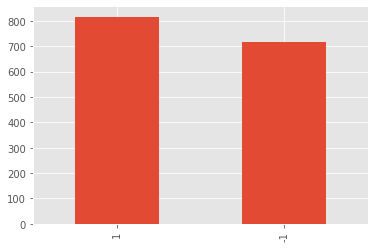

In [13]:
#Chart of Rise/fall
ax = sc_df["Rise/Fall"].value_counts().plot(kind = "bar")

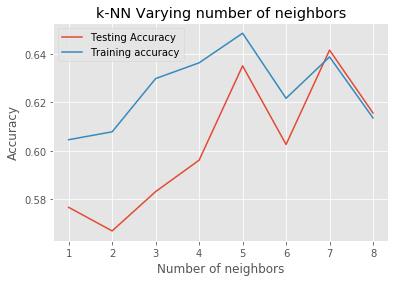

The accuracy score for KNN is: 0.5960912052117264


In [14]:
## KNN 
 
X = sc_df.drop(columns=['Adj Close','Date','Stock','stock_price_change','Category','Rise/Fall'],axis=1).values
y = sc_df['Rise/Fall'].values



#Splitting into test and train
X_train,X_test,y_train,y_test = tts(X,y,test_size=0.2,random_state=42, stratify=y)


#Arrays to store data accuracy
neighbors = np.arange(1,9)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))


for i,k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)
    
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

# Fitting the model with k=4
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)
    
train_accuracy = knn.score(X_train, y_train)
test_accuracy = knn.score(X_test, y_test) 

#Accuracy:
print("The accuracy score for KNN is:",test_accuracy)

In [15]:
#Confusion Matrix
y_pred = knn.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,-1,1,All
True,,,
-1,106,37,143
1,87,77,164
All,193,114,307


In [16]:
# Calculating Measures by hand
TP = 71
FP = 29
FN = 49
TN = 74
recall = TP/(TP+FN)
precision= TP/(TP+FP)
fmeasure = (2*recall*precision)/(recall+precision)
print("Recall: ",recall, "\nPrecision: ",precision, "\nF Measure: ", fmeasure)

Recall:  0.5916666666666667 
Precision:  0.71 
F Measure:  0.6454545454545454


In [17]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.55      0.74      0.63       143
           1       0.68      0.47      0.55       164

    accuracy                           0.60       307
   macro avg       0.61      0.61      0.59       307
weighted avg       0.62      0.60      0.59       307



In [18]:
## Random Forest Classifier

rfc = RandomForestClassifier()

features=["tot_cases", "case_change", "tot_death", "death_change"]

X = sc_df.loc[:, features]
Y = sc_df["Rise/Fall"]
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size=0.2, random_state=42)

rfc.fit(X_train, Y_train)
Y_pred = rfc.predict(X_test)

In [19]:
accuracy = metrics.accuracy_score(Y_test, Y_pred)
print("The accuracy score for random forest classifier is:", accuracy)

The accuracy score for random forest classifier is: 0.6775244299674267


In [20]:
pd.crosstab(Y_test, Y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,-1,1,All
True,,,
-1,71,64,135
1,35,137,172
All,106,201,307


In [21]:
TP = 81
FP = 37
FN = 47
TN = 58
recall = TP/(TP+FN)
precision = TP/(TP+FP)
fmeasure = (2*recall*precision)/(recall+precision)
print("Recall: ",recall, "\nPrecision: ",precision, "\nF Measure: ", fmeasure)

Recall:  0.6328125 
Precision:  0.6864406779661016 
F Measure:  0.6585365853658537


In [22]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

          -1       0.67      0.53      0.59       135
           1       0.68      0.80      0.73       172

    accuracy                           0.68       307
   macro avg       0.68      0.66      0.66       307
weighted avg       0.68      0.68      0.67       307



In [23]:
# pairwise correlation of columns
covid_stocks_dummies = pd.concat([sc_df, pd.get_dummies(sc_df["Category"], prefix="Dummy")], axis = 1)
covid_stocks_dummies.corr()

,Adj Close,stock_price_change,tot_cases,new_case,tot_death,new_death,case_change,death_change,Dummy_biotech,Dummy_consumer,Dummy_energy,Dummy_healthCare,Dummy_it,Dummy_pharmacy,Dummy_realEstate,Dummy_retail,Dummy_utility
Adj Close,1.000000,0.106580,0.035810,0.023369,0.035763,0.029330,-0.002085,-0.002326,-0.129508,-0.025398,-0.108457,-0.072905,-0.076794,-0.079641,0.057917,0.454338,-0.034675
stock_price_change,0.106580,1.000000,0.005321,0.018144,0.006124,0.021601,-0.000638,-0.001023,0.000654,0.001822,-0.000434,-0.002220,-0.001402,0.000086,-0.000453,0.001297,0.001578
tot_cases,0.035810,0.005321,1.000000,0.443383,0.988248,0.640794,0.171233,0.178832,-0.003166,-0.002992,-0.004952,-0.004952,-0.003719,-0.004952,-0.004952,0.031340,-0.002992
new_case,0.023369,0.018144,0.443383,1.000000,0.399833,0.711600,0.280831,0.188318,-0.002195,-0.002444,-0.004045,-0.004045,-0.003038,-0.004045,-0.004045,0.025193,-0.002444
tot_death,0.035763,0.006124,0.988248,0.399833,1.000000,0.591064,0.168654,0.179963,-0.002826,-0.002871,-0.004750,-0.004750,-0.003568,-0.004750,-0.004750,0.029844,-0.002871
new_death,0.029330,0.021601,0.640794,0.711600,0.591064,1.000000,0.324621,0.320158,-0.001557,-0.002424,-0.004011,-0.004011,-0.003013,-0.004011,-0.004011,0.024333,-0.002424
case_change,-0.002085,-0.000638,0.171233,0.280831,0.168654,0.324621,1.000000,0.991574,0.000162,0.000069,0.000114,0.000114,0.000086,0.000114,0.000114,-0.000815,0.000069
death_change,-0.002326,-0.001023,0.178832,0.188318,0.179963,0.320158,0.991574,1.000000,0.000355,0.000186,0.000308,0.000308,0.000231,0.000308,0.000308,-0.002112,0.000186
Dummy_biotech,-0.129508,0.000654,-0.003166,-0.002195,-0.002826,-0.001557,0.000162,0.000355,1.000000,-0.095799,-0.158532,-0.158532,-0.119071,-0.158532,-0.158532,-0.148764,-0.095799
Dummy_consumer,-0.025398,0.001822,-0.002992,-0.002444,-0.002871,-0.002424,0.000069,0.000186,-0.095799,1.000000,-0.096065,-0.096065,-0.072153,-0.096065,-0.096065,-0.090146,-0.058051


In [24]:

finalVars = ["Rise/Fall","stock_price_change",
             "death_change","case_change",
             "Dummy_biotech", "Dummy_consumer",
             "Dummy_energy", "Dummy_it","Dummy_pharmacy",
             "Dummy_retail", "Dummy_utility"]
final = covid_stocks_dummies.loc[:,finalVars]
final.corr()

,stock_price_change,death_change,case_change,Dummy_biotech,Dummy_consumer,Dummy_energy,Dummy_it,Dummy_pharmacy,Dummy_retail,Dummy_utility
stock_price_change,1.000000,-0.001023,-0.000638,0.000654,0.001822,-0.000434,-0.001402,0.000086,0.001297,0.001578
death_change,-0.001023,1.000000,0.991574,0.000355,0.000186,0.000308,0.000231,0.000308,-0.002112,0.000186
case_change,-0.000638,0.991574,1.000000,0.000162,0.000069,0.000114,0.000086,0.000114,-0.000815,0.000069
Dummy_biotech,0.000654,0.000355,0.000162,1.000000,-0.095799,-0.158532,-0.119071,-0.158532,-0.148764,-0.095799
Dummy_consumer,0.001822,0.000186,0.000069,-0.095799,1.000000,-0.096065,-0.072153,-0.096065,-0.090146,-0.058051
Dummy_energy,-0.000434,0.000308,0.000114,-0.158532,-0.096065,1.000000,-0.119400,-0.158970,-0.149176,-0.096065
Dummy_it,-0.001402,0.000231,0.000086,-0.119071,-0.072153,-0.119400,1.000000,-0.119400,-0.112044,-0.072153
Dummy_pharmacy,0.000086,0.000308,0.000114,-0.158532,-0.096065,-0.158970,-0.119400,1.000000,-0.149176,-0.096065
Dummy_retail,0.001297,-0.002112,-0.000815,-0.148764,-0.090146,-0.149176,-0.112044,-0.149176,1.000000,-0.090146
Dummy_utility,0.001578,0.000186,0.000069,-0.095799,-0.058051,-0.096065,-0.072153,-0.096065,-0.090146,1.000000


RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

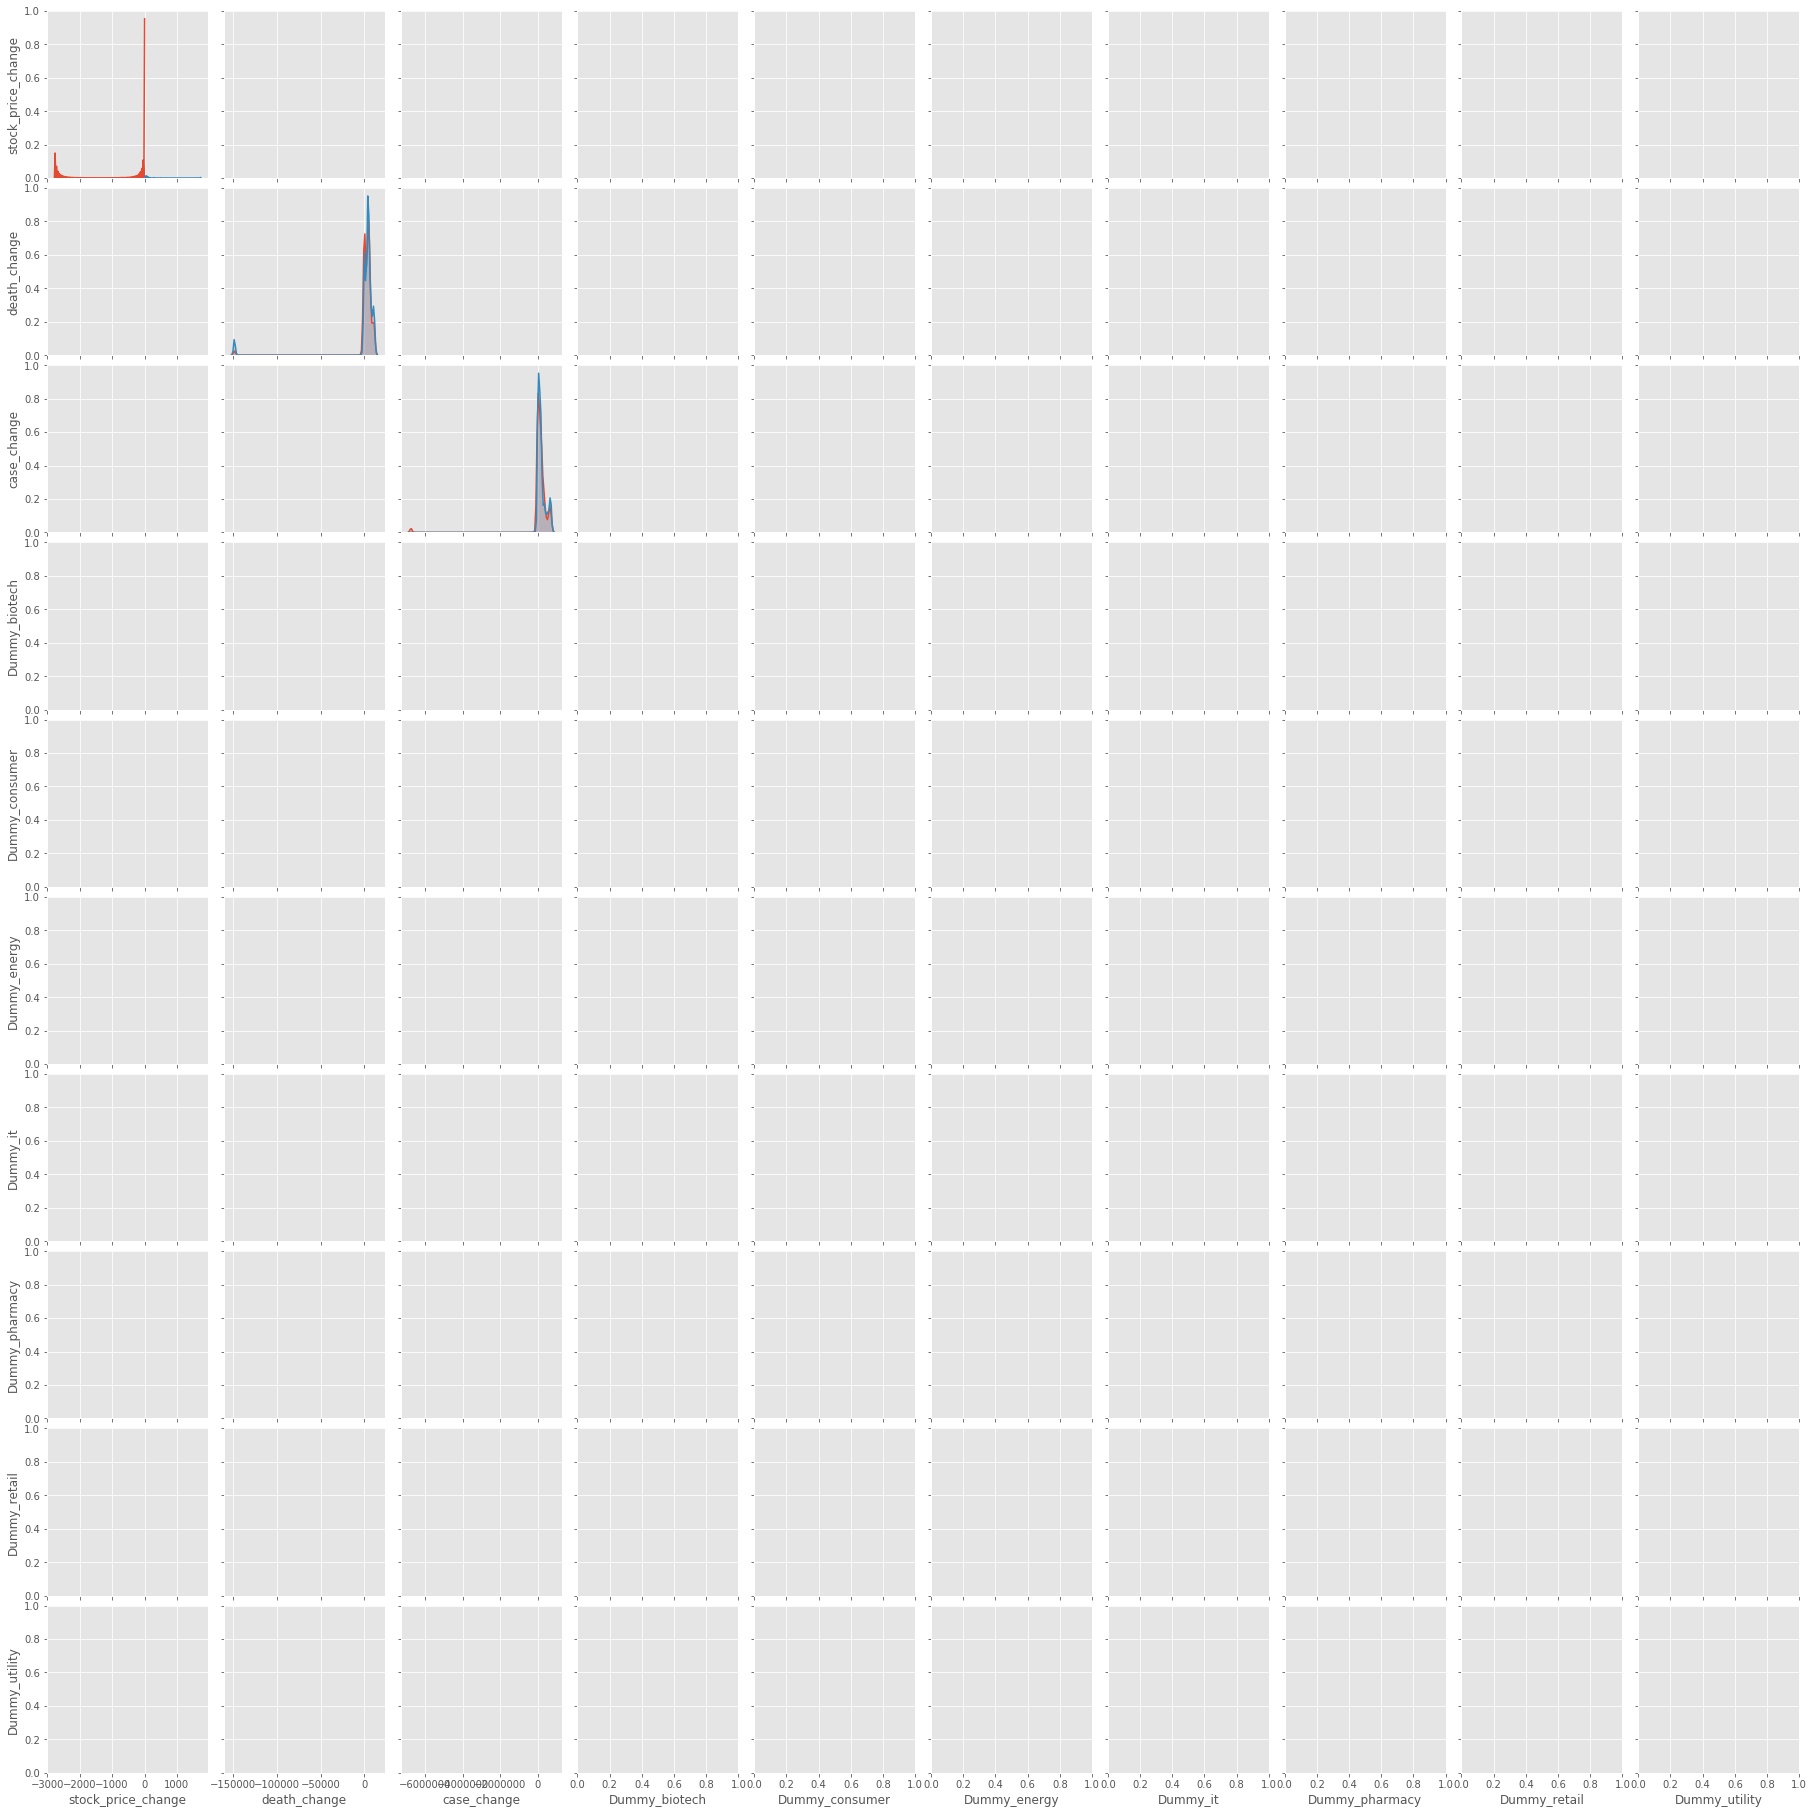

In [25]:
sns.pairplot(final, hue = "Rise/Fall", diag_kind = "kde", plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'})